In [1]:
#Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
import pickle
warnings.filterwarnings('ignore')

# Own modules and libraries
import estimators.v_information as v_information
import source.utils as ut
import source.pipes as op
import source.fairness as fm


# Plot
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
#Re import libraries
import imp
imp.reload(ut)
imp.reload(op)
imp.reload(fm)
imp.reload(v_information)

<module 'estimators.v_information' from '/Users/jonathanvasquezverdugo/PHD-GMU/Research & Projects/DispaRisk/estimators/v_information.py'>

# Loading Data and Parameters

In [3]:
data_sets = {}

DIR_DATA = {
    'dutch_census': 'data/dutch_census/',
    'census_income':'data/census_income/',
    'compas': 'data/compas/'
}

data_names = {    
    'dutch_census': 'DC',
    'census_income':'CI',
    'compas': 'CR'}

model_names={
    'sgd_lr':'Linear',  
    'mlp_one_layer': '1MLP', 
    'mlp_two_layer':'2MLP',
}

cols = ['model', 'dataset', 'id_scenario', 'acc_train_mean', 'acc_train_sd', 'acc_test',
        'f1_train_mean', 'f1_train_sd', 'f1_test', 'log_loss_train_mean' ,
        'log_loss_train_sd', 'log_loss_test', 'demp', 'eqopp', 'eqodd']


for data in DIR_DATA:
    with open (DIR_DATA[data]+data+'.pkl', 'rb') as f:
        dic = pickle.load(f)
    
    data_sets[data] = dic

In [14]:
performances_disparities = pd.DataFrame()

for ds in DIR_DATA.keys():
    for m in model_names:
        perfos = pd.read_csv(f'results/{m}/{ds}_results.txt')
        perfos['model'] = [m]*perfos.shape[0]
        perfos['dataset'] = [ds]*perfos.shape[0]
        performances_disparities = pd.concat([performances_disparities, perfos], axis=0, ignore_index=True)

performances_disparities

,id_scenario,acc_train_mean,acc_train_sd,acc_test,f1_train_mean,f1_train_sd,f1_test,log_loss_train_mean,log_loss_train_sd,log_loss_test,demp,eqopp,eqodd,model,dataset
0,0,0.800373,0.003660,0.804259,0.812913,0.003490,0.820935,0.454481,0.004726,0.453729,-0.183724,-0.044865,0.048410,sgd_lr,dutch_census
1,1,0.800350,0.003611,0.804259,0.812886,0.003437,0.820935,0.454481,0.004727,0.453728,-0.183724,-0.044865,0.048410,sgd_lr,dutch_census
2,2,0.800279,0.003746,0.804204,0.812806,0.003621,0.820929,0.454489,0.004716,0.453756,-0.183828,-0.044727,0.048090,sgd_lr,dutch_census
3,3,0.800373,0.003596,0.804259,0.812913,0.003429,0.820935,0.454487,0.004720,0.453746,-0.183724,-0.044865,0.048410,sgd_lr,dutch_census
4,4,0.799972,0.003599,0.804149,0.812625,0.003292,0.821032,0.454674,0.004697,0.453976,-0.183256,-0.044633,0.048584,sgd_lr,dutch_census
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,49,0.662708,0.007926,0.687298,0.593645,0.017348,0.625346,0.648795,0.020021,0.603325,-0.221860,-0.238604,0.185268,mlp_two_layer,compas
644,50,0.649241,0.018782,0.654503,0.564932,0.025085,0.588559,0.873566,0.031528,0.785760,-0.182074,-0.189958,0.151739,mlp_two_layer,compas
645,51,0.656368,0.011048,0.666975,0.573310,0.011264,0.616693,0.917037,0.198038,0.850585,-0.204820,-0.195646,0.170154,mlp_two_layer,compas
646,52,0.659146,0.021818,0.671132,0.600620,0.022593,0.641490,0.650129,0.036190,0.615632,-0.232876,-0.202036,0.195189,mlp_two_layer,compas


In [18]:
# Replace model names:
for name in model_names:
    performances_disparities['model'] = performances_disparities['model'].replace(name, model_names[name])
# Replace dataset names
for name in data_names:    
    performances_disparities['dataset'] = performances_disparities['dataset'].replace(name, data_names[name])

# Make abosolute the values of disparity metrics
performances_disparities['demp'] = abs(performances_disparities['demp'])
performances_disparities['eqopp'] = abs(performances_disparities['eqopp'])
performances_disparities['eqodd'] = abs(performances_disparities['eqodd'])

In [25]:
model_names.values()

dict_values(['Linear', '1MLP', '2MLP'])

In [32]:
results_filtered = pd.DataFrame(columns = performances_disparities.columns)

sns.set(font_scale=1.4)

for perc in range(10, 91, 10):
    for ds in data_names:
        ds_eq = data_names[ds]
        for m in model_names.values():
            p = np.percentile(performances_disparities[(performances_disparities['model']==m) & (performances_disparities['dataset']==ds_eq)].acc_test, perc)
            filtered = performances_disparities[(performances_disparities['model']==m) & 
                                                (performances_disparities['dataset']==ds_eq) & 
                                                (performances_disparities['acc_test']>=p)]
            filtered['top'] = [f'{100-perc}%']*filtered.shape[0]
            results_filtered = pd.concat([results_filtered, filtered], axis=0, ignore_index=True)

In [33]:
results_filtered.columns

Index(['id_scenario', 'acc_train_mean', 'acc_train_sd', 'acc_test',
       'f1_train_mean', 'f1_train_sd', 'f1_test', 'log_loss_train_mean',
       'log_loss_train_sd', 'log_loss_test', 'demp', 'eqopp', 'eqodd', 'model',
       'dataset', 'top'],
      dtype='object')

In [34]:
# computing the mean of eqopp for model in result_filtered
results_filtered.loc[results_filtered['top']=="10%",['dataset','model','demp']].groupby(['dataset','model']).mean()

demp
dataset model           
CI      1MLP    0.172844
        2MLP    0.171132
        Linear  0.134161
CR      1MLP    0.209933
        2MLP    0.211312
        Linear  0.195422
DC      1MLP    0.194201
        2MLP    0.191587
        Linear  0.187556

In [35]:
# computing the mean of eqopp for model in result_filtered
results_filtered.loc[results_filtered['top']=="10%",['dataset','model','acc_test']].groupby(['dataset','model']).mean()

acc_test
dataset model           
CI      1MLP    0.851944
        2MLP    0.851688
        Linear  0.821126
CR      1MLP    0.693764
        2MLP    0.693303
        Linear  0.690271
DC      1MLP    0.822051
        2MLP    0.822284
        Linear  0.805050

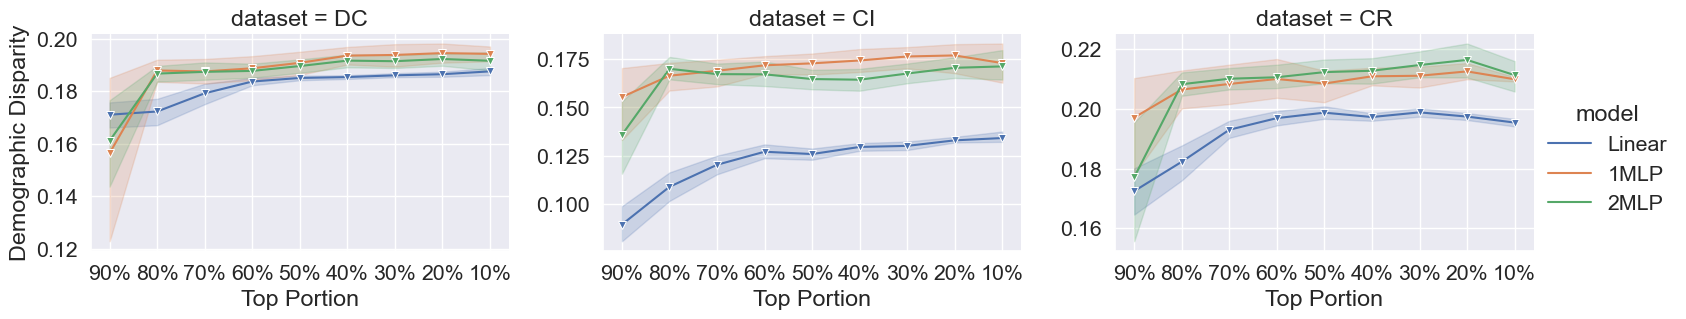

In [36]:
columns = list(results_filtered.columns)
columns[np.where(results_filtered.columns=='top')[0][0]] = 'Top Portion'
columns[np.where(results_filtered.columns=='demp')[0][0]] = 'Demographic Disparity'

results_filtered.columns = columns

sns.relplot(data=results_filtered,
            x='Top Portion',
            y='Demographic Disparity',
            hue='model',
            col='dataset',
            kind='line',
            marker='v',
            height=3.5, aspect=1.5, 
            facet_kws=dict(sharey=False))

plt.show()

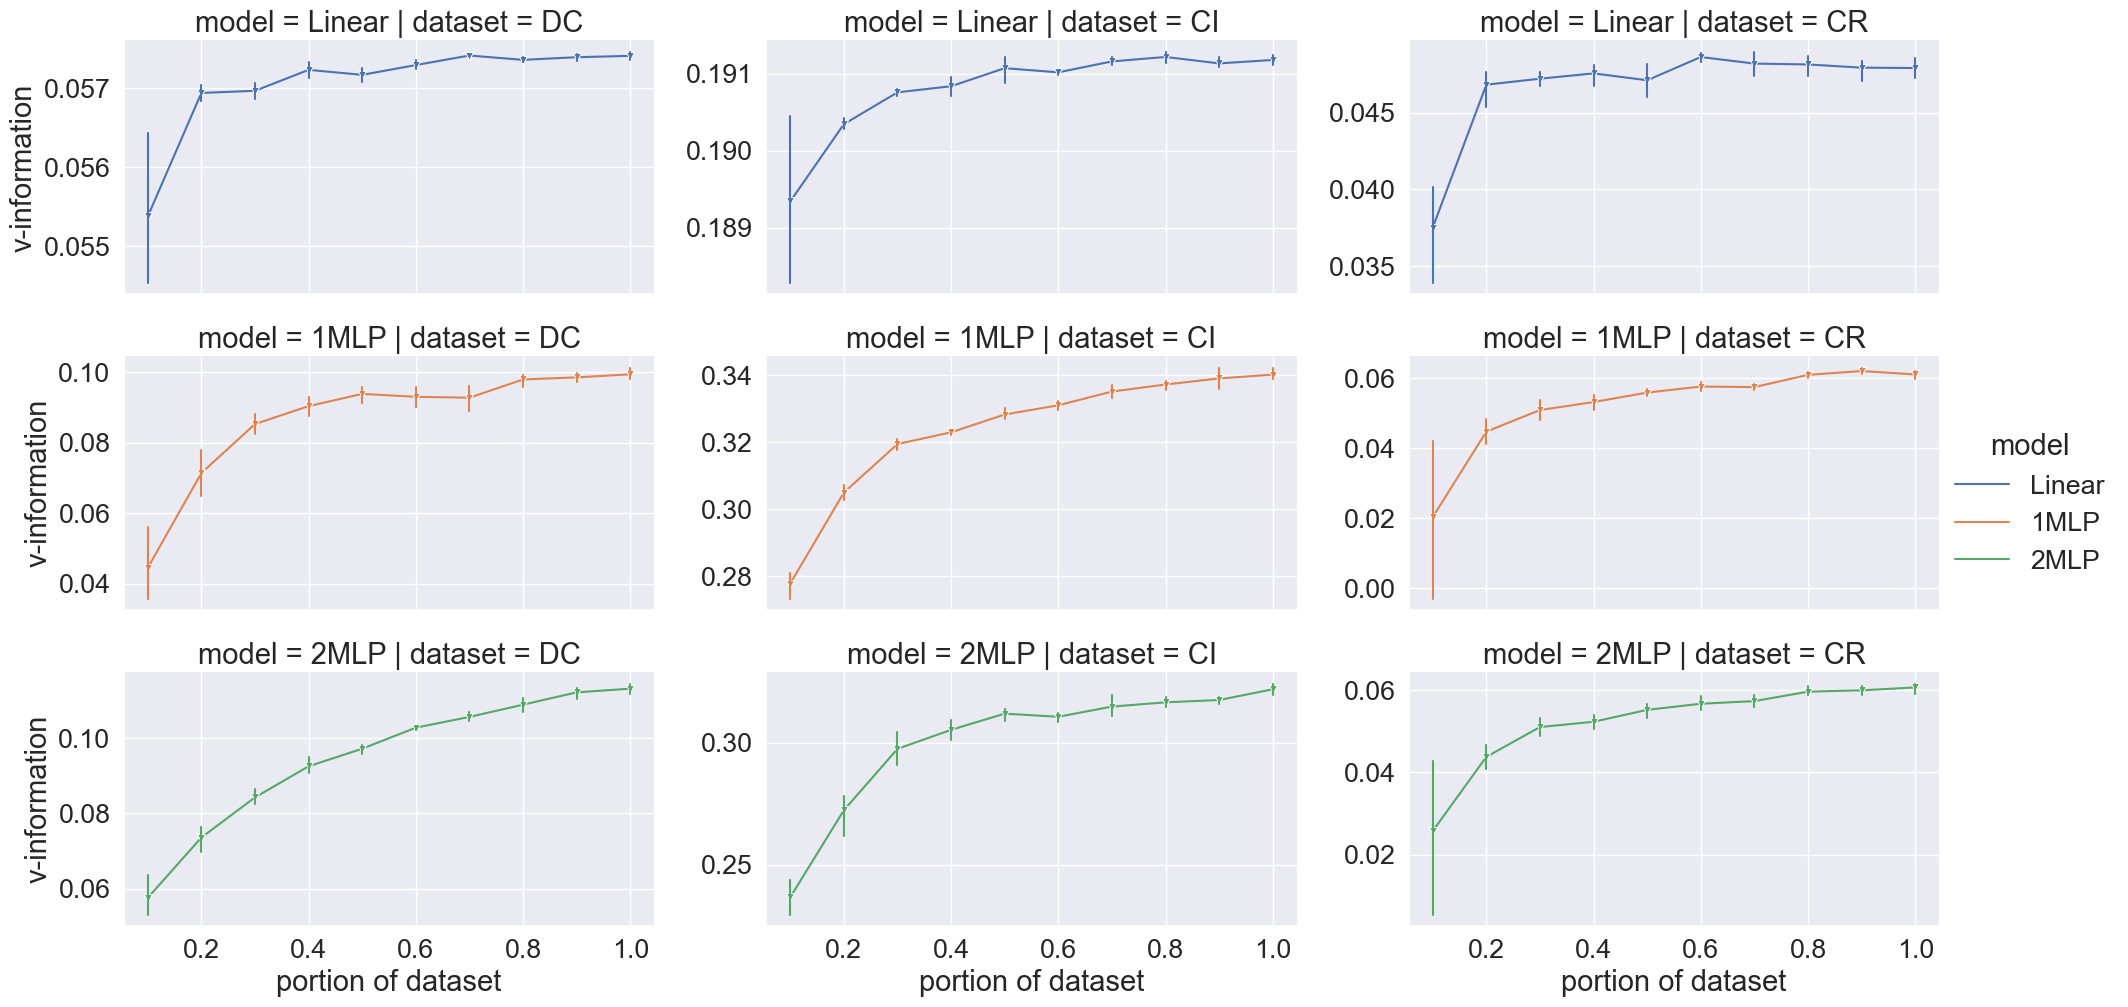

In [37]:
sns.set(font_scale=1.75)
result_train_size = pd.read_csv(f'size_training.csv')
result_train_size['dataset'] = result_train_size['dataset'].replace('dutch_census', 'DC').replace('census_income', 'CI').replace('german_data', 'GC').replace('compas', 'CR')
result_train_size['model'] = result_train_size['model'].replace('sgd_lr', 'Linear').replace('mlp_one_layer', '1MLP').replace('mlp_two_layer', '2MLP')
result_train_size['portion'] = result_train_size['portion']/100
result_train_size.columns = ['dataset', 'model', 'scenario', 'portion of dataset', 'v-information']
sns.relplot(data=result_train_size, 
            x='portion of dataset',
            y='v-information',
            hue='model',
            col='dataset',
            row='model',
            kind='line',
            marker='v',
            err_style="bars",
            height=3.5, aspect=1.9, 
            facet_kws=dict(sharey=False))
plt.show()

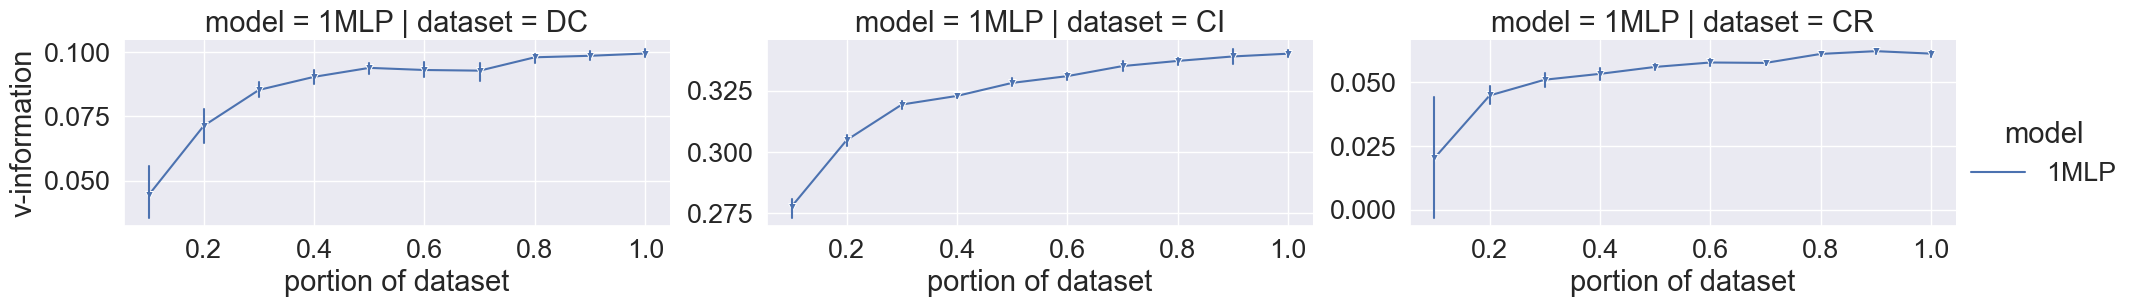

In [38]:
sns.relplot(data=result_train_size[result_train_size['model']=='1MLP'], 
            x='portion of dataset',
            y='v-information',
            hue='model',
            col='dataset',
            row='model',
            kind='line',
            marker='v',
            err_style="bars",
            height=3.5, aspect=1.9, 
            facet_kws=dict(sharey=False))
